#### Import Libraries

In [5]:
# import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import sklearn
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
import random
RANDOM_STATE = 42
import pprint
import seaborn as sns
pd.set_option('display.max_columns', None)


In [6]:
# # !pip install jupyterthemes
# !jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T

#### Load Datasets

In [7]:
# load the data
link = 'C:/Crop Yield Prediction/'
train_df = pd.read_csv(link + 'Train.csv') # training dataframe
test_field_ids_years_df = pd.read_csv(link + 'test_field_ids_with_year.csv') # years for the test fields
add_info_df = pd.read_csv(link + 'fields_w_additional_info.csv') # additional soil and climate information
sample_sub_df = pd.read_csv(link + 'SampleSubmission.csv') 

#### View Imageries

Loading C:/Crop Yield Prediction/image_arrays_train/image_arrays_train/Q458HJX.npy as an array
Array shape: (360, 41, 41)


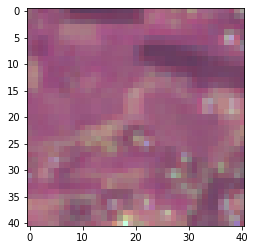

In [30]:
# Veiwing a sentinel2 Imagery
# Look at a sample:
train_folder =  'C:/Crop Yield Prediction/image_arrays_train/image_arrays_train/'

fid = train_df['Field_ID'].sample().values[0]
fn =  train_folder + fid + '.npy'                       #File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

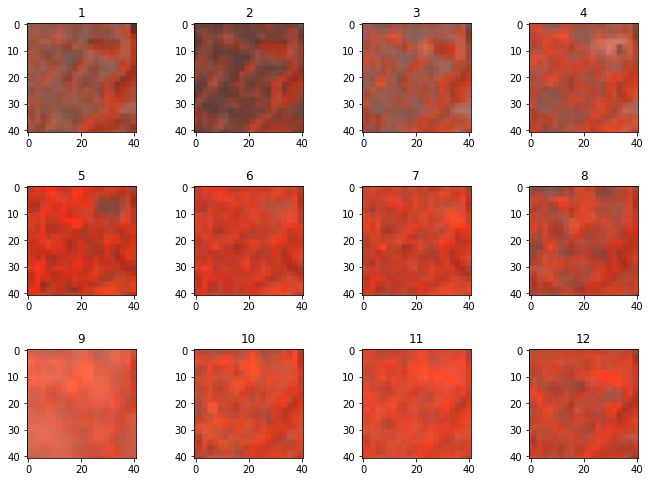

In [28]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i  in range(12):
  rgb = np.stack([arr[i*30 +8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

#### View Band Names

In [36]:
band_names = [l.strip() for l in open(link + 'bandnames.txt', 'r').readlines()]
print(band_names)

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

#### Remove Bad Quality Locations

In [37]:
# remove poor quality locations from the train dataframe
train_df = train_df[train_df['Quality'] != 1]
train_df.Quality.unique()

array([3, 2], dtype=int64)

#### Specify Bands of Interest and Center Point

In [38]:
def process_im(fid, folder='C:/Crop Yield Prediction/image_arrays_train/image_arrays_train/'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  bands_of_interest = ['S2_B11', 'S2_B8', 'S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
  return values

#### Turn Sampled Values into a DataFrame

In [39]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train_df['Field_ID'].values])
print(train_sampled.shape, train_df.shape)
print(train_sampled.columns)
train_sampled.head()

(2552, 96) (2552, 4)
Index(['0_S2_B11', '0_S2_B8', '0_S2_B5', '0_S2_B4', '0_S2_B3', '0_S2_B2',
       '0_CLIM_pr', '0_CLIM_soil', '1_S2_B11', '1_S2_B8', '1_S2_B5', '1_S2_B4',
       '1_S2_B3', '1_S2_B2', '1_CLIM_pr', '1_CLIM_soil', '2_S2_B11', '2_S2_B8',
       '2_S2_B5', '2_S2_B4', '2_S2_B3', '2_S2_B2', '2_CLIM_pr', '2_CLIM_soil',
       '3_S2_B11', '3_S2_B8', '3_S2_B5', '3_S2_B4', '3_S2_B3', '3_S2_B2',
       '3_CLIM_pr', '3_CLIM_soil', '4_S2_B11', '4_S2_B8', '4_S2_B5', '4_S2_B4',
       '4_S2_B3', '4_S2_B2', '4_CLIM_pr', '4_CLIM_soil', '5_S2_B11', '5_S2_B8',
       '5_S2_B5', '5_S2_B4', '5_S2_B3', '5_S2_B2', '5_CLIM_pr', '5_CLIM_soil',
       '6_S2_B11', '6_S2_B8', '6_S2_B5', '6_S2_B4', '6_S2_B3', '6_S2_B2',
       '6_CLIM_pr', '6_CLIM_soil', '7_S2_B11', '7_S2_B8', '7_S2_B5', '7_S2_B4',
       '7_S2_B3', '7_S2_B2', '7_CLIM_pr', '7_CLIM_soil', '8_S2_B11', '8_S2_B8',
       '8_S2_B5', '8_S2_B4', '8_S2_B3', '8_S2_B2', '8_CLIM_pr', '8_CLIM_soil',
       '9_S2_B11', '9_S2_B8', '9_S2_B5',

,0_S2_B11,0_S2_B8,0_S2_B5,0_S2_B4,0_S2_B3,0_S2_B2,0_CLIM_pr,0_CLIM_soil,1_S2_B11,1_S2_B8,1_S2_B5,1_S2_B4,1_S2_B3,1_S2_B2,1_CLIM_pr,1_CLIM_soil,2_S2_B11,2_S2_B8,2_S2_B5,2_S2_B4,2_S2_B3,2_S2_B2,2_CLIM_pr,2_CLIM_soil,3_S2_B11,3_S2_B8,3_S2_B5,3_S2_B4,3_S2_B3,3_S2_B2,3_CLIM_pr,3_CLIM_soil,4_S2_B11,4_S2_B8,4_S2_B5,4_S2_B4,4_S2_B3,4_S2_B2,4_CLIM_pr,4_CLIM_soil,5_S2_B11,5_S2_B8,5_S2_B5,5_S2_B4,5_S2_B3,5_S2_B2,5_CLIM_pr,5_CLIM_soil,6_S2_B11,6_S2_B8,6_S2_B5,6_S2_B4,6_S2_B3,6_S2_B2,6_CLIM_pr,6_CLIM_soil,7_S2_B11,7_S2_B8,7_S2_B5,7_S2_B4,7_S2_B3,7_S2_B2,7_CLIM_pr,7_CLIM_soil,8_S2_B11,8_S2_B8,8_S2_B5,8_S2_B4,8_S2_B3,8_S2_B2,8_CLIM_pr,8_CLIM_soil,9_S2_B11,9_S2_B8,9_S2_B5,9_S2_B4,9_S2_B3,9_S2_B2,9_CLIM_pr,9_CLIM_soil,10_S2_B11,10_S2_B8,10_S2_B5,10_S2_B4,10_S2_B3,10_S2_B2,10_CLIM_pr,10_CLIM_soil,11_S2_B11,11_S2_B8,11_S2_B5,11_S2_B4,11_S2_B3,11_S2_B2,11_CLIM_pr,11_CLIM_soil
0,934,932,1173,1392,2038,2907,4,287,1015,1036,1397,1516,2095,3091,7,236,1034,1075,1518,1640,2084,3207,14,200,1048,1085,1455,1561,1951,2930,47,175,1024,1084,1449,1605,2031,3002,76,155,6305,6128,6432,6511,6944,5690,88,139,749,611,360,518,1346,507,72,126,1743,1487,1272,1743,2740,2198,92,116,903,928,1155,1322,1862,2454,81,107,893,998,903,1307,2642,2317,96,99,841,894,690,1162,2373,1782,83,93,744,699,393,790,1845,985,125,215
1,880,821,924,1116,1951,2404,4,287,933,873,1011,1152,1695,2468,7,237,905,881,1020,1167,1758,2581,15,203,1893,1888,2178,2344,2906,3668,50,178,906,882,916,1037,1983,2353,80,158,943,803,506,677,2307,897,86,142,922,922,679,1031,3673,2005,67,130,850,848,679,939,2453,1690,92,119,891,873,943,1135,1908,2419,74,110,841,844,817,1098,2126,2315,79,102,806,862,512,1037,3818,1832,78,96,703,524,323,420,891,469,126,215
2,1016,1070,1357,1632,2137,3567,4,278,1108,1193,1588,1947,2381,3815,7,230,978,1018,1346,1472,1780,3112,15,197,1086,1117,1426,1584,1971,3280,50,173,1045,1095,1460,1663,2097,3455,77,154,8621,8414,8875,8692,9601,6923,83,139,843,822,491,841,4262,1610,65,126,838,798,552,859,2790,1622,89,116,845,908,764,1215,2670,1975,69,107,833,896,796,1186,2463,2090,73,100,967,1091,929,1538,3163,2603,75,93,2935,2961,3598,4145,4173,4898,135,289
3,777,784,639,1064,2588,2123,3,299,832,875,823,1237,2582,2431,8,244,878,903,916,1231,2406,2575,14,207,932,907,973,1254,2242,2627,48,180,858,858,844,1108,2210,2409,79,159,914,846,570,902,3136,1480,90,143,1475,1348,1135,1311,2939,1648,75,130,3057,2836,2781,2997,3226,2132,94,119,764,779,501,982,3262,1796,85,109,798,823,581,1039,3036,1897,106,102,776,784,537,947,2716,1681,86,95,7289,7389,8025,8057,8648,7406,121,189
4,1081,1122,1162,1487,2603,2986,20,427,1046,1063,1133,1454,2230,2643,18,300,1222,1339,1542,1834,2949,3376,35,234,985,1072,1046,1462,2890,2783,179,384,826,826,507,851,3621,1660,159,568,874,819,534,805,3261,1550,66,370,912,912,644,1029,3243,1791,29,273,980,995,882,1130,2699,1995,75,218,889,959,698,1178,3229,1993,85,182,923,984,694,1223,3179,2249,237,1179,973,958,657,1050,2696,1620,122,1123,1054,1097,789,1349,3455,2428,194,1214


#### Feature Engineering using Indices


#### Normalized Difference Vegetation Index (NDVI)

In [40]:
# NDVI = NIR-Red/NIR+Red = Band8-Band4/Band8+Band4
for i in range(12):
    train_sampled['NDVI_Month_' + str(i)] = (train_sampled[str(i) + '_S2_B8'] - train_sampled[str(i) + '_S2_B4'])/(train_sampled[str(i) + '_S2_B8'] + train_sampled[str(i) + '_S2_B4'])

#### Enhanced Vegetation Index (EVI)

In [41]:
# EVI = (NIR - RED)/(NIR + C1 * RED - C2 * Blue + l)
for i in range(12):
    train_sampled['EVI_Month_' + str(i)] = 2.5* ((train_sampled[str(i) + '_S2_B8'] 
                                                  - train_sampled[str(i) + '_S2_B4'])/((train_sampled[str(i) + '_S2_B8']) + (6 * train_sampled[str(i) + '_S2_B4'])- (7.5 * train_sampled[str(i) + '_S2_B2'])+1))

#### Soil Adjusted Vegetation Index (SAVI)

In [42]:
# SAVI = ((NIR - RED)/ (NIR + RED + L))*(1 + L)
for i in range(12):
    train_sampled['SAVI_Month_' + str(i)] = ((train_sampled[str(i) + '_S2_B8']
                                              - train_sampled[str(i) + '_S2_B4']) / (train_sampled[str(i) + '_S2_B8']
                                             + train_sampled[str(i) + '_S2_B4'] + 1)) * (1 + 1)
    

#### Atmospherically Resistant Vegetation Index (ARVI)

In [43]:
## ARVI = (NIR – (2 * Red) + Blue) / (NIR + (2 * Red) + Blue)
for i in range(12):
    train_sampled['ARVI_Month_' + str(i)] = (train_sampled[str(i) + '_S2_B8']
                                             -(2*train_sampled[str(i) + '_S2_B4']) 
                                             + train_sampled[str(i) + '_S2_B2']) / (train_sampled[str(i) + '_S2_B8']
                                             +(2*train_sampled[str(i) + '_S2_B4']) 
                                             + train_sampled[str(i) + '_S2_B2'])

#### Green Chlorophyll Index(GCI)

In [44]:
## GCI = (NIR) / (Green) – 1
for i in range(12):
    train_sampled['GCI_Month_' + str(i)] = (train_sampled[str(i) + '_S2_B8'])/(train_sampled[str(i) + '_S2_B3'])-1

#### Structure Insensitive Pigment Index (SIPI)

In [45]:
## SIPI = (NIR – Blue) / (NIR – Red)
for i in range(12):
    train_sampled['SIPI_Month_' + str(i)] = (train_sampled[str(i) + '_S2_B8']
                                             - train_sampled[str(i) + '_S2_B2'])/(train_sampled[str(i) + '_S2_B8'] 
                                                                                  - train_sampled[str(i) + '_S2_B4'])

#### Normalized Difference Water Index (NDWI)

In [46]:
## NDWI = (NIR-SWIR)/(NIR+SWIR)
for i in range(12):
    train_sampled['NDWI_Month_' + str(i)] = (train_sampled[str(i) + '_S2_B8']
                                                - train_sampled[str(i) + '_S2_B11'])/(train_sampled[str(i) + '_S2_B8']
                                                                                      + train_sampled[str(i) + '_S2_B11'])
    

#### Split Dataset into Train and Test

In [47]:
train_df.shape

(2552, 4)

In [349]:
# Add in the field ID and yield
train_sampled['Field_ID'] = train_df['Field_ID'].values
train_sampled['Yield'] = train_df['Yield'].values

In [350]:
# Split the data
X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Fit Model

In [351]:
model = lgb.LGBMRegressor(n_estimators=1000)
model.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
          early_stopping_rounds=10)
# Score with RMSE
print(" ")
print('Score:', mean_squared_error(y_test, model.predict(X_test), squared=False))

[1]	valid_0's l2: 2.54617
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 2.4541
[3]	valid_0's l2: 2.37621
[4]	valid_0's l2: 2.32464
[5]	valid_0's l2: 2.28602
[6]	valid_0's l2: 2.24578
[7]	valid_0's l2: 2.20668
[8]	valid_0's l2: 2.19805
[9]	valid_0's l2: 2.19298
[10]	valid_0's l2: 2.19342
[11]	valid_0's l2: 2.18734
[12]	valid_0's l2: 2.19076
[13]	valid_0's l2: 2.18456
[14]	valid_0's l2: 2.18215
[15]	valid_0's l2: 2.177
[16]	valid_0's l2: 2.17574
[17]	valid_0's l2: 2.18145
[18]	valid_0's l2: 2.19258
[19]	valid_0's l2: 2.1926
[20]	valid_0's l2: 2.19284
[21]	valid_0's l2: 2.1973
[22]	valid_0's l2: 2.19873
[23]	valid_0's l2: 2.19981
[24]	valid_0's l2: 2.19582
[25]	valid_0's l2: 2.20397
[26]	valid_0's l2: 2.20852
Early stopping, best iteration is:
[16]	valid_0's l2: 2.17574
 
Score: 1.4750403596862713


In [185]:
# Load the sample submission file
ss = sample_sub_df

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='C:/Crop Yield Prediction/image_arrays_test/image_arrays_test/') for fid in ss['Field_ID'].values])

# Get model predictions
preds = model.predict(test_sampled)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('C:\Crop Yield Prediction\Sub_6_3_57_PM.csv', index=False)
ss.head()

,Field_ID,Yield
0,E9UZCEA,3.632237
1,1WGGS1Q,3.026097
2,EG2KXE2,3.701146
3,HC3GQXF,3.572709
4,7AK6GFK,4.188187
